# Time Series Analysis 

The study of time series has arisen because certain sorts of data streams are heavily dependent on the flow of time. Of course, we have not totally ignored time as a feature up to this point. The selling price of a house probably does have some relation to the season or the year as real estate markets grow and decline with certain temporally-indexed economic changes etc. But surely time is not the most important predictor of house price. Square footage would likely be more strongly correlated with price than would date of sale.

But there are other sorts of data that more readily lend themselves to a temporal analysis. One canonical example is numbers from a stock exchange: First, data from stock tickers often arrive as numbers anchored to consecutive units of time. I get the selling price for some stock on January 1, say, and the next bit of information I gain will be the selling price for that stock on January 2. (We'll explore this feature of time series below.) Second, and more important, if I'm interested in actually predicting the selling price of a stock for, say, tomorrow, then very likely one piece of very salient (i.e. correlated) information would be the selling price of that stock today.

What other examples of this sort of time-dependent data can you think of?

    * Births/day or year in countries
    
    * Current trends: Census data/Covid-19/Airline/Zoom stocks/Bitcoin 
    
    * Sales of products

In [1]:
# Let's load some packages.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.read_csv('data/google-trends_game-of-thrones_us.csv').head()

,Category: All categories
Month,"""game of thrones"": (United States)"
2004-01,<1
2004-02,<1
2004-03,<1
2004-04,<1


In [3]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [4]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})

The `**` syntax is used to pass keywords and values in dictionary form to a function. For more on `*` and `**` (`*args` and `**kwargs`), see [this page](https://www.geeksforgeeks.org/args-kwargs-python/).

In [5]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'game-of-thrones', 'country_code': 'us'},
    {'trend_name': 'pokemon', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},   
]

In [6]:
np.random.shuffle(trends)

In [7]:
trend_dfs = [load_trend(**trend) for trend in trends]

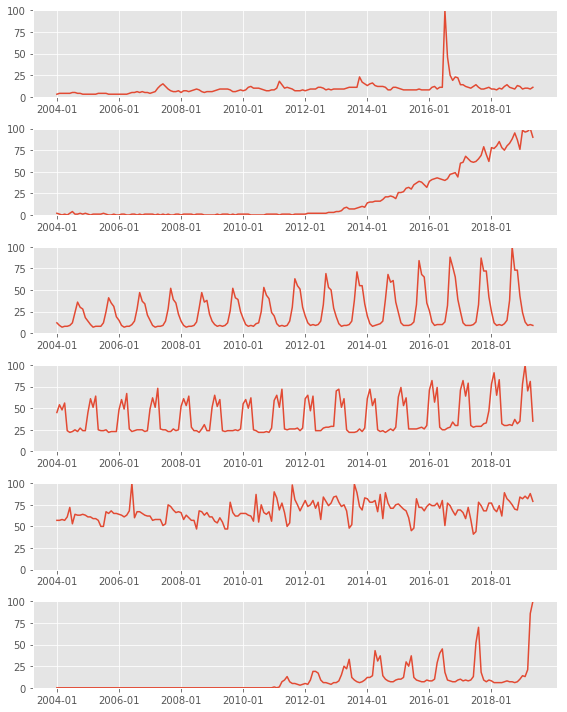

In [9]:
# Let's see if we can guess which is which just by looking
# at their graphs.

import matplotlib; matplotlib.style.use('ggplot')

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    #ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

We could do a histogram of our data, say of the taxes counts:

In [10]:
taxes_df = load_trend('taxes')
taxes_df.head()

,counts
2004-01,45
2004-02,54
2004-03,48
2004-04,56
2004-05,24


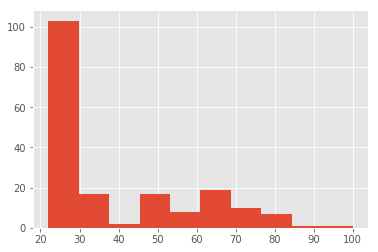

In [11]:
plt.hist(taxes_df['counts']);

This doesn't help us capture the information visually of time series data. Let's do some EDA/light modeling using the taxes data. 

In [12]:
taxes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 2004-01 to 2019-05
Data columns (total 1 columns):
counts    185 non-null int64
dtypes: int64(1)
memory usage: 2.9+ KB


## Pre-processing

Before you begin EDA on a time series dataset, there a few things to consider. 
1. Make sure your dates/times are 'non-null datetime' objects not 'non-null objects'.
2. Set the datetime object as the index. Why? 
    - most important aspect of the data
    - many of the methods we use for analysis require this
3. Deal with missing data. What new options do we have available? 
    - ffill() - fills missing values with previous value 
    - bfill() - fills the missing values with the next valid entry
    CONS: Trend/seasonal components be influential with these methods
4. Use down/up sampling or slicing to manage the data that you want. What are the drawbacks to using down sampling or up sampling? 
* Downsampling drawback - Introduce missing data. You lose data.
* Upsampling drawback - Missing data. Increasing the size of the dataset

## Making Predictions 
Let's use month to predict tax activity 

In [13]:
# Adding a month column

taxes_df['i'] = np.arange(len(taxes_df))
taxes_df['month'] = taxes_df['i'] % 12

In [14]:
taxes_df.head(20)

,counts,i,month
2004-01,45,0,0
2004-02,54,1,1
2004-03,48,2,2
2004-04,56,3,3
2004-05,24,4,4
2004-06,22,5,5
2004-07,23,6,6
2004-08,25,7,7
2004-09,23,8,8
2004-10,27,9,9


In [15]:
trend_model = LinearRegression()
trend_model.fit(taxes_df[['i']], taxes_df['counts'])
trend_line = trend_model.predict(taxes_df[['i']])

In [16]:
trend_line[:10]

array([31.65754141, 31.73558811, 31.81363481, 31.89168151, 31.96972821,
       32.04777491, 32.12582161, 32.20386831, 32.28191501, 32.35996171])

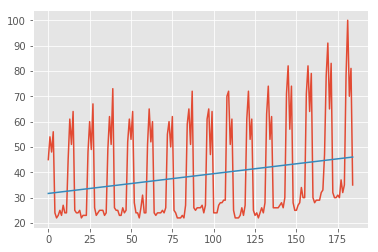

In [17]:
plt.plot(taxes_df['i'], taxes_df['counts'])
plt.plot(taxes_df['i'], trend_line);

Clearly, this model leaves something to be desired! Let's try again. And this time we'll make explicit use of the time indices.

In [18]:
month_encoder = OneHotEncoder(categories='auto')
month_encoder.fit(taxes_df[['month']])
month_data = month_encoder.transform(taxes_df[['month']]).toarray()

In [20]:
month_data[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
lr = LinearRegression()

In [22]:
data = np.hstack((taxes_df[['i']].values, month_data))

In [23]:
lr.fit(data, taxes_df['counts'])
lr_pred = lr.predict(data)  # Predictive model based on i and month

In [24]:
lr_pred[:5]

array([52.63422131, 63.19672131, 46.88422131, 60.50922131, 19.63422131])

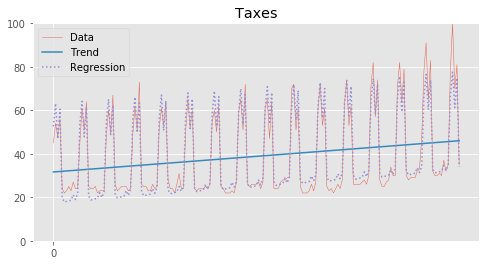

In [25]:
trend_df = taxes_df
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Taxes')
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], trend_line, label='Trend')
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((0, 100))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

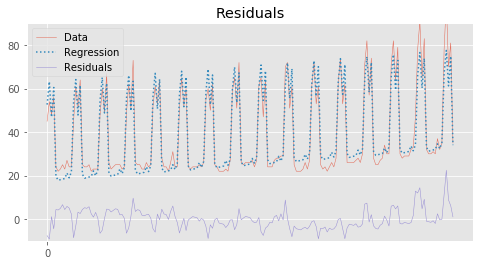

In [26]:
residuals = trend_df['counts'] - lr_pred

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Residuals")
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
ax.plot(trend_df['i'], residuals,
        label='Residuals', linewidth=.5)

#ax.plot(trend_df.index, trend_line, label='trend')
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((-10, 90))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

## Decomposing a Time Series with StatsModels 

Statsmodels has a great tool for looking at a time series as a sum of parts: a general trend, a seasonality component, and whatever is left over (often called a residual (why?)): its seasonal_decompose() function.

In [27]:
taxes_df.index = pd.to_datetime(taxes_df.index)

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(taxes_df['counts'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [29]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

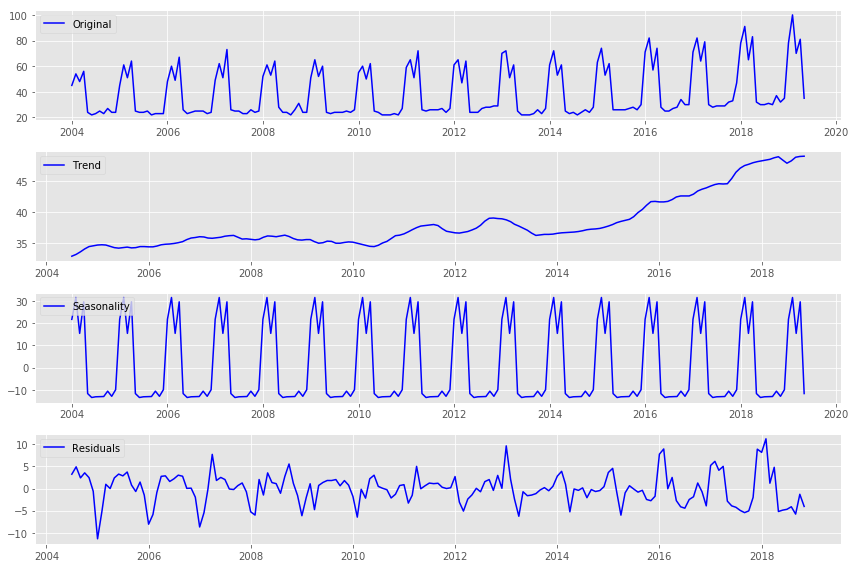

In [30]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts. (we will explore this more tomorrow with an ARIMA model)
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [31]:
residual.mean()

-0.039666005291003725

For various techincal reasons that won't concern us here, some of the components of the decomposition have NANs at their heads and tails. But we can just use np.nansum() - a function that is used when we want to compute the sum of array elements over a given axis treating (NaNs) as zero.

In [32]:
myst = 0
for i in range(len(taxes_df['counts'])):
    myst += np.nansum(taxes_df['counts'][i] - trend[i] - seasonal[i] - residual[i])
myst

0.0